# Import Packages

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import sklearn
import statsmodels.api as sm
import statsmodels.tsa.stattools as sts
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
from arch import arch_model
import yfinance

# Load the Data

In [20]:
raw_data = yfinance.download(tickers="^GSPC ^FTSE ^N225 ^GDAXI", start="1994-01-07", end="2019-09-01", interval="1d", group_by="ticker", auto_adjust=True)

[*********************100%***********************]  4 of 4 completed


In [21]:
# copy of the data
df_comp = raw_data.copy()

# Data Preprocessing

In [22]:
# get the closing prices
df_comp["spx"] = df_comp["^GSPC"].Close[:]
df_comp["dax"] = df_comp["^GDAXI"].Close[:]
df_comp["ftse"] = df_comp["^FTSE"].Close[:]
df_comp["nikkei"] = df_comp["^N225"].Close[:]
df_comp.head()

^GDAXI                                                 
                   Open         High          Low        Close Volume   
Date                                                                    
1994-01-07  2218.959961  2227.639893  2201.820068  2224.949951    0.0  \
1994-01-10  2231.840088  2238.010010  2222.000000  2225.000000    0.0   
1994-01-11  2225.429932  2235.610107  2225.179932  2228.100098    0.0   
1994-01-12  2227.120117  2227.790039  2182.060059  2182.060059    0.0   
1994-01-13  2171.500000  2183.709961  2134.100098  2142.370117    0.0   

                 ^GSPC                                                   ...   
                  Open        High         Low       Close       Volume  ...   
Date                                                                     ...   
1994-01-07  467.089996  470.260010  467.029999  469.899994  324920000.0  ...  \
1994-01-10  469.899994  475.269989  469.549988  475.269989  319490000.0  ...   
1994-01-11  475.269989  475.279999  473.269989  474.130005  305490000.0  ...   
1994-01-12  474.130005  475.059998  472.140015  474.170013  310690000.0  ...   
1994-01-13  474.170013  474.170013  471.799988  472.470001  277970000.0  ...   

            ^N225        ^FTSE                                                 
           Volume         Open         High          Low        Close Volume   
Date                                                                           
1994-01-07    0.0  3401.399902  3446.800049  3398.699951  3446.000000    0.0  \
1994-01-10    0.0  3465.699951  3468.100098  3430.000000  3440.600098    0.0   
1994-01-11    0.0  3442.500000  3442.500000  3413.500000  3413.800049    0.0   
1994-01-12    0.0  3394.800049  3402.399902  3372.000000  3372.000000    0.0   
1994-01-13    0.0  3380.699951  3383.300049  3356.899902  3360.000000    0.0   

                   spx          dax         ftse        nikkei  
                                                                
Date                                                            
1994-01-07  469.899994  2224.949951  3446.000000  18124.009766  
1994-01-10  475.269989  2225.000000  3440.600098  18443.439453  
1994-01-11  474.130005  2228.100098  3413.800049  18485.250000  
1994-01-12  474.170013  2182.060059  3372.000000  18793.880859  
1994-01-13  472.470001  2142.370117  3360.000000  18577.259766  

[5 rows x 24 columns]

In [23]:
# delete the other columns
df_comp = df_comp.iloc[1:]
del df_comp["^N225"]
del df_comp["^GSPC"]
del df_comp["^GDAXI"]
del df_comp["^FTSE"]

# set the frequency and forward fill the missing values
df_comp = df_comp.asfreq("b")
df_comp = df_comp.fillna(method="ffill")

In [24]:
# create returns
df_comp["ret_spx"] = df_comp.spx.pct_change(1).mul(100)
df_comp["ret_ftse"] = df_comp.ftse.pct_change(1).mul(100)
df_comp["ret_dax"] = df_comp.dax.pct_change(1).mul(100)
df_comp["ret_nikkei"] = df_comp.nikkei.pct_change(1).mul(100)

In [25]:
# normalize returns
df_comp["norm_ret_spx"] = df_comp.ret_spx.div(df_comp.ret_spx[1]) * 100
df_comp["norm_ret_ftse"] = df_comp.ret_ftse.div(df_comp.ret_ftse[1]) * 100
df_comp["norm_ret_dax"] = df_comp.ret_dax.div(df_comp.ret_dax[1]) * 100
df_comp["norm_ret_nikkei"] = df_comp.ret_nikkei.div(df_comp.ret_nikkei[1]) * 100

In [26]:
# split the data
size = int(len(df_comp) * 0.8)
df, df_test = df_comp.iloc[:size], df_comp.iloc[size:]

# Forecasting

In [31]:
# start with an AR
model_ar = ARIMA(df.ftse, order=(1,0,0))
results_ar = model_ar.fit()

In [52]:
# forecasting starts from the first day of the test set
start_date = '2014-07-16'
end_date = '2019-01-01'

In [53]:
# get the predictions
df_pred = results_ar.predict(start=start_date, end=end_date)

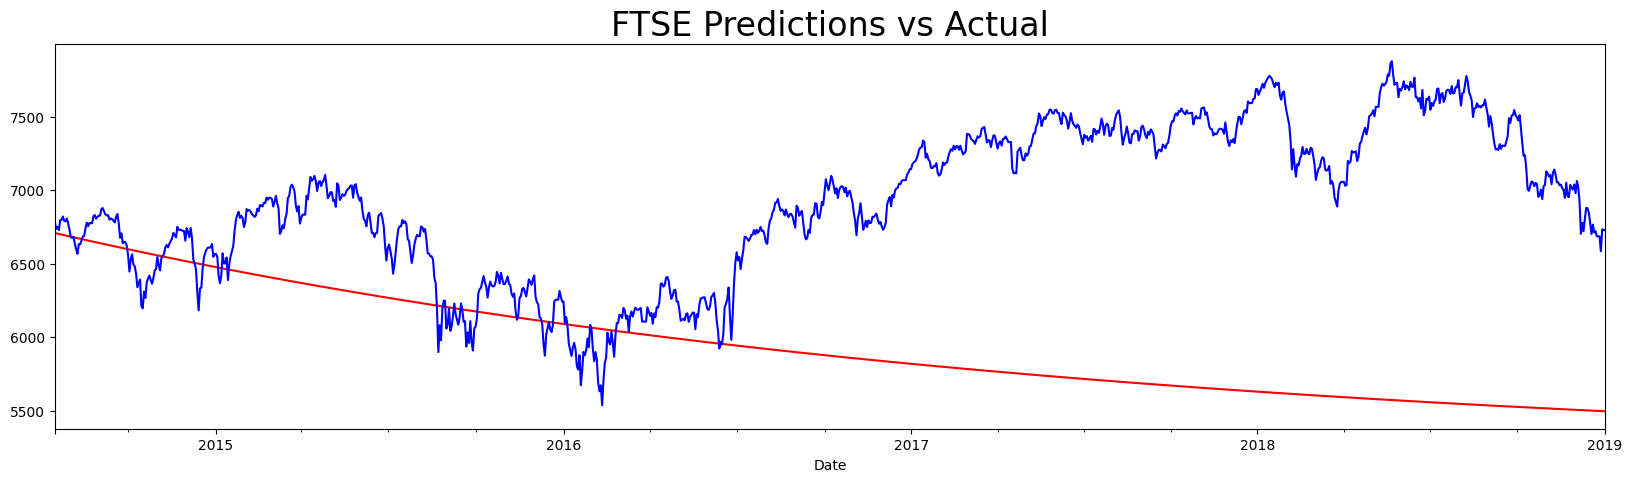

In [55]:
# plot the predictions
df_pred[start_date:end_date].plot(figsize=(20,5), color="red")
df_test.ftse[start_date:end_date].plot(color="blue")
plt.title("FTSE Predictions vs Actual", size=24)
plt.show()

The predictions are only based on a constant and the previous value. this is why we get a straight line, since each value is a fraction of the previous one, plus a constant term.  
AR models aren't the best for non stationary data.

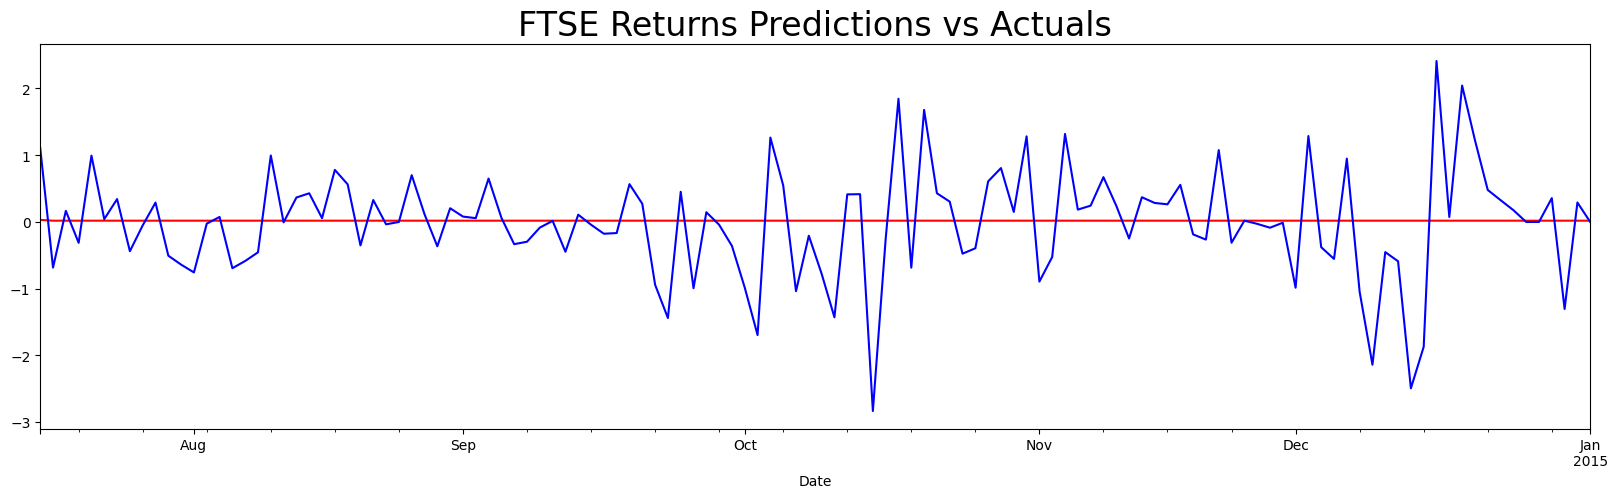

In [85]:
# use returns
end_date = '2015-01-01'

model_ret_ar = ARIMA(df.ret_ftse[1:], order=(1,0,0))
results_ret_ar = model_ret_ar.fit()

# get the predictions
df_pred = results_ret_ar.predict(start=start_date, end=end_date)

# plot the predictions
df_pred[start_date:end_date].plot(figsize=(20,5), color="red")
df_test.ret_ftse[start_date:end_date].plot(color="blue")
plt.title("FTSE Returns Predictions vs Actuals", size=24)
plt.show()

The model estimates no returns.

In [86]:
results_ret_ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               ret_ftse   No. Observations:                 5351
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -8343.712
Date:                Sun, 30 Apr 2023   AIC                          16693.424
Time:                        23:11:34   BIC                          16713.179
Sample:                    01-11-1994   HQIC                         16700.324
                         - 07-15-2014                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0191      0.016      1.226      0.220      -0.011       0.050
ar.L1         -0.0224      0.008     -2.740      0.006      -0.038      -0.006
sigma2         1.3240      0.013    104.612      0.000       1.299       1.349
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              8959.57
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               1.91   Skew:                            -0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The coefficients are low and not even significant.

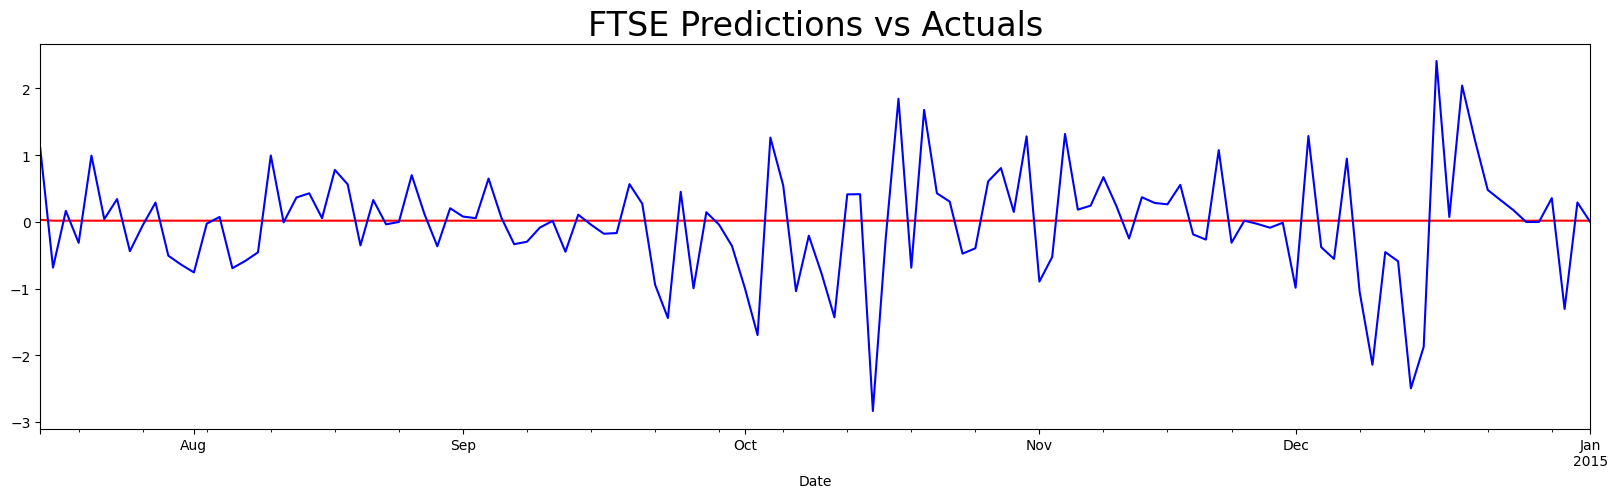

In [87]:
# MA model
model_ret_ma = ARIMA(df.ret_ftse[1:], order=(0,0,1))
results_ret_ma = model_ret_ma.fit()

# get the predictions
df_pred = results_ret_ma.predict(start=start_date, end=end_date)

# plot the predictions
df_pred[start_date:end_date].plot(figsize=(20,5), color="red")
df_test.ret_ftse[start_date:end_date].plot(color="blue")
plt.title("FTSE Predictions vs Actuals", size=24)
plt.show()

Similar pattern.

In [88]:
df_pred.head()

2014-07-16    0.032249
2014-07-17    0.019113
2014-07-18    0.019113
2014-07-21    0.019113
2014-07-22    0.019113
Freq: B, Name: predicted_mean, dtype: float64

We see that all the predictions have the same values.  
MA and AR models are bad predictors.

e:\User\Documents\Personal\projects\machine-learning\forecasting-ts\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
e:\User\Documents\Personal\projects\machine-learning\forecasting-ts\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


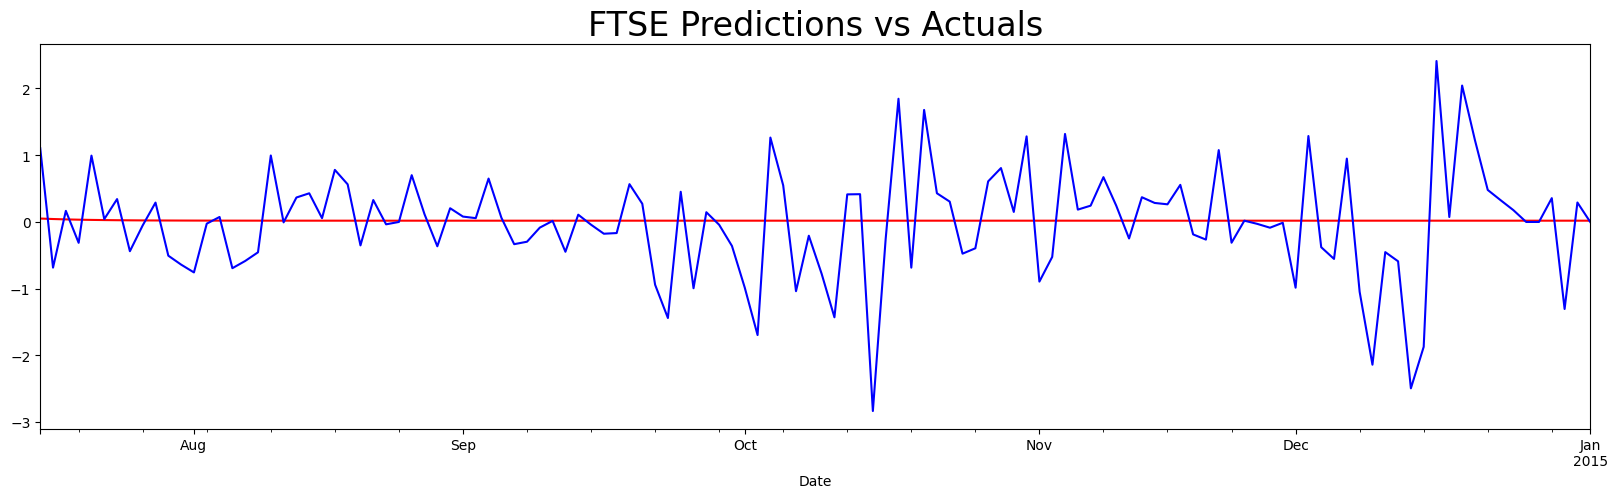

In [89]:
# ARMA
model_ret_arma = ARIMA(df.ret_ftse[1:], order=(1,0,1))
results_ret_arma = model_ret_arma.fit()

# get the predictions
df_pred = results_ret_arma.predict(start=start_date, end=end_date)

# plot the predictions
df_pred[start_date:end_date].plot(figsize=(20,5), color="red")
df_test.ret_ftse[start_date:end_date].plot(color="blue")
plt.title("FTSE Predictions vs Actuals", size=24)
plt.show()

In [90]:
df_pred.head()

2014-07-16    0.051308
2014-07-17    0.044092
2014-07-18    0.038497
2014-07-21    0.034157
2014-07-22    0.030792
Freq: B, Name: predicted_mean, dtype: float64

We have constantly decreasing returns, which is not realistic.

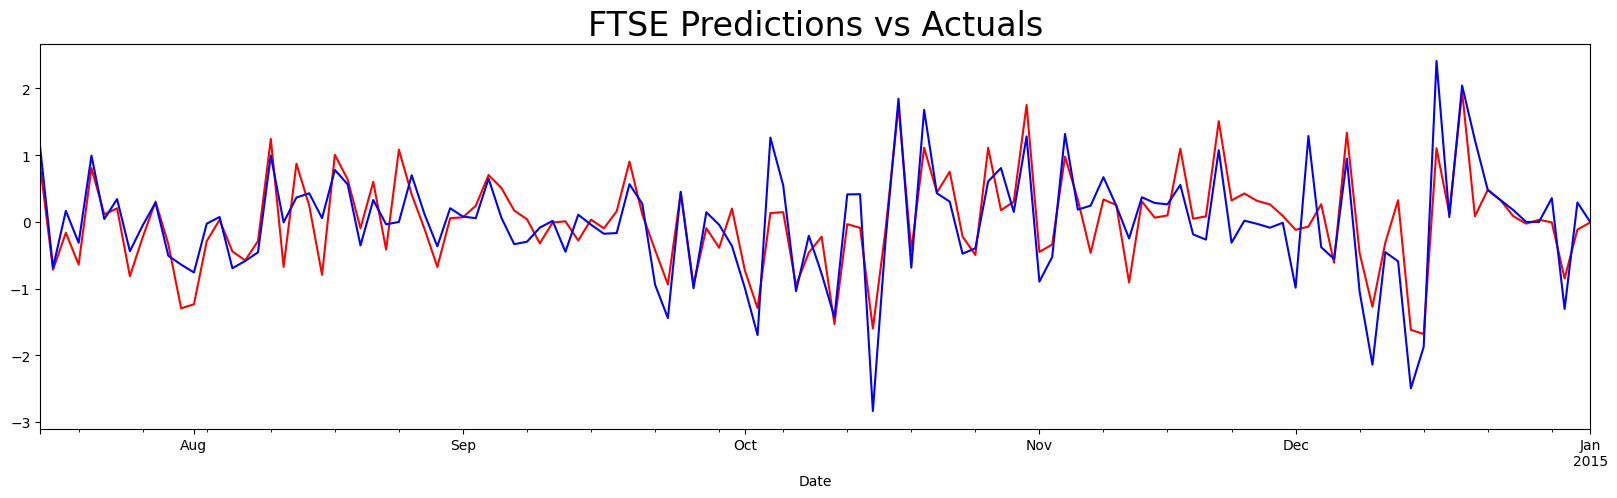

In [93]:
# ARMAX
model_ret_armax = ARIMA(df.ret_ftse[1:], exog=df[["ret_spx", "ret_dax", "ret_nikkei"]][1:], order=(1,0,1))
results_ret_armax = model_ret_armax.fit()

# get the predictions
df_pred = results_ret_armax.predict(start=start_date, end=end_date, exog=df_test[["ret_spx", "ret_dax", "ret_nikkei"]][start_date:end_date])

# plot the predictions
df_pred[start_date:end_date].plot(figsize=(20,5), color="red")
df_test.ret_ftse[start_date:end_date].plot(color="blue")
plt.title("FTSE Predictions vs Actuals", size=24)
plt.show()

Our predictions follow the data really well, meaning that the outside factors impact the data a lot.  
MAX models cannot forecast because when we forecast, we don't have the future values of the outside factors.

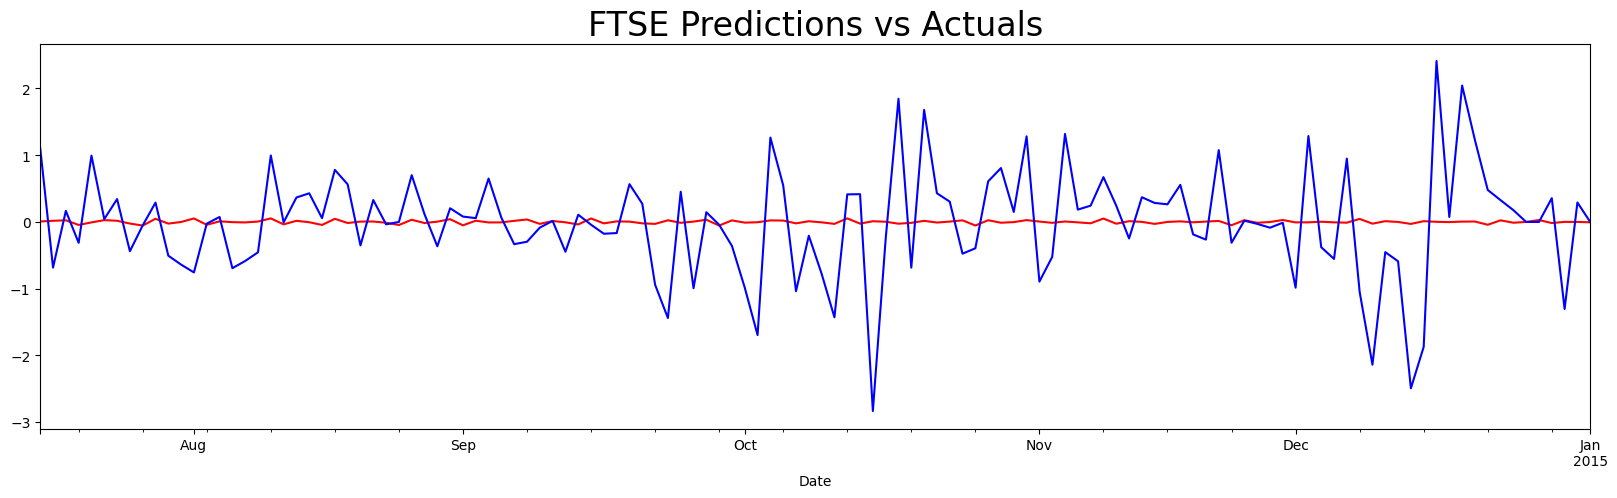

In [95]:
# SARMA
model_ret_sarma = SARIMAX(df.ret_ftse[1:], order=(3,0,4), seasonal_order=(3,0,2,5), )
results_ret_sarma = model_ret_sarma.fit(maxiter=200)

# get the predictions
df_pred = results_ret_sarma.predict(start=start_date, end=end_date)

# plot the predictions
df_pred[start_date:end_date].plot(figsize=(20,5), color="red")
df_test.ret_ftse[start_date:end_date].plot(color="blue")
plt.title("FTSE Predictions vs Actuals", size=24)
plt.show()

Compared to the actual data, the magnitude of the predictions is really low. But we can tell that the SARMA model is better than the ARMA model, since we see oscillations in the predictions.

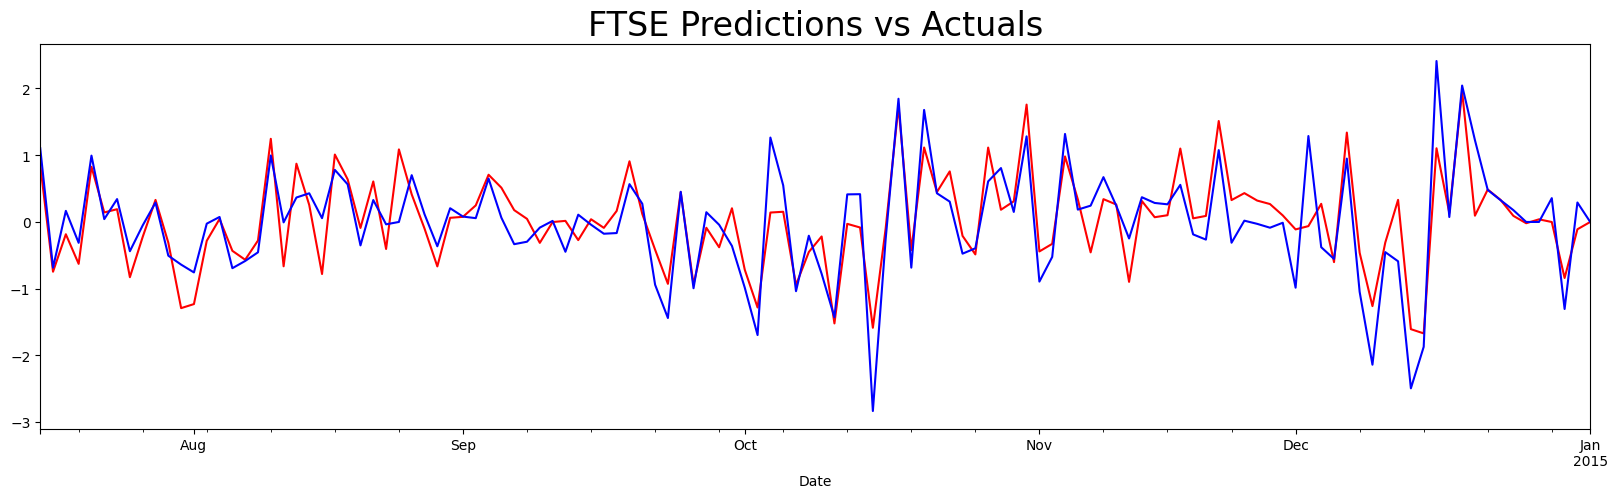

In [96]:
# SARMAX
model_ret_sarimax = SARIMAX(df.ret_ftse[1:], exog=df[["ret_spx", "ret_dax", "ret_nikkei"]][1:], order=(3,0,4), seasonal_order=(3,0,2,5))
results_ret_sarimax = model_ret_sarimax.fit(maxiter=200)

# get the predictions
df_pred = results_ret_sarimax.predict(start=start_date, end=end_date, exog=df_test[["ret_spx", "ret_dax", "ret_nikkei"]][start_date:end_date])

# plot the predictions
df_pred[start_date:end_date].plot(figsize=(20,5), color="red")
df_test.ret_ftse[start_date:end_date].plot(color="blue")
plt.title("FTSE Predictions vs Actuals", size=24)
plt.show()

This time as well, adding the external factors improved the model.

In [97]:
# auto_arima (we don't use the fit method because this function returns the model already fitted)
model_auto = auto_arima(df.ret_ftse[1:])

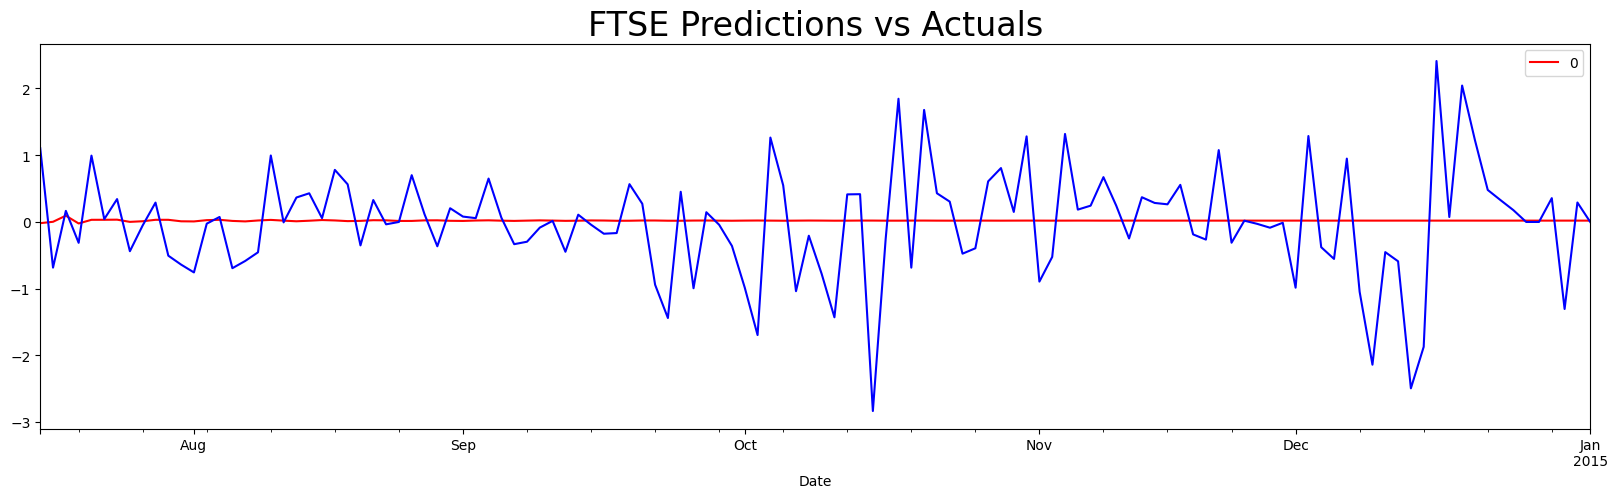

In [98]:
# get the predictions
y_pred = pd.DataFrame(model_auto.predict(n_periods=len(df_test[start_date:end_date])), index=df_test[start_date:end_date].index)

# plot the predictions
y_pred.plot(figsize=(20,5), color="red")
df_test.ret_ftse[start_date:end_date].plot(color="blue")
plt.title("FTSE Predictions vs Actuals", size=24)
plt.show()

The predictions again, don't match the curve of the actual data.  
This means that as long as we provide the model with external factors, it will be able to predict the data well.